# **Predceir Eficiencia de Veichulos**
En este ejemplo, vamos a crear una red neuronal que se encargara de predceir la eficiencia de veichulos entre 1970 y 1980.
>
Los datos los encontramos en la Universidad de California.

In [1]:

%tensorflow_version 2.x
import tensorflow as tf

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


# **Preparar los datos**

In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")


In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()


In [4]:
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [6]:
print(dataset['Origin'].min())
print(dataset['Origin'].max())

1
3


Verificamos si contiene valores na o null.
>
En un entorno real es habitual encontrarnos con la situación de que nos faltan valores de los datos de muestra, solucionarlo no siempre es una tarea facil.
>
Una forma de solucionarlo es usando estimadores para intnear estimar esos valores, eso con ScikitLearn es muy cómodo de realizar o también podemos eliminar las carcterísticas, esto no siempre es la mejor opción ya que podemos cambiar la distribución de los datos de entrada, borrar información importante etc



In [7]:
print(dataset.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [8]:
dataset=dataset.dropna()

La columna origin no es numérica, sinó categórica, es decir el 1 es USA, el 2 es Europa y el 3 es Japan.
>
Cuando nos encontramos con esta situación, lo que se suele hacer es usar la técnica de codificación one-hot.

In [9]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [10]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   USA           392 non-null    float64
 8   Europe        392 non-null    float64
 9   Japan         392 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 33.7 KB


# **Separación de los datos de entrenamiento**
>
En este caso nos encontramos un solo grupo de datos y debemos decidir nosotros mismos cuáles usaremos para el entrenamiento y cuáles para la evaluación del modelo.
>
Normalmente dividimos los datos en 2 conjunto : datos de entrenamiento y datos de prueba, a su vez una parte de los datos de entrenamiento se reservan como datos de validación.
>
Los datos de entrenamiento, que nos quedan despues de sacar los de validación y prueba son los que se usan para qeu el algoritme calcule los parámetros del modelo, mientras que los de validación se usan para afinar los hiperparámtetros.
>
La importancia de disponer de un conjutno de datos de prueba reservados para una prueba final,que el mnodelo nunca ha visto antes, permite obtener una medida de comportamiento del algoritmo más objetiva y evaluar si nuestro modelo generaliza bien o no.
>
Cabe destacar que podemos encontrar otras estrategias de evluación, como la validación cruzada(croos-validation), que es habitual cuando tenemos escasez de datos.Dividimos los datos en k particiones del mismo tamaño y para cada partición i el modelo es entrenado con la k-1 particiones restantes y evaluado con la propia partición i.
>
En nuestro ejemplo vamos a dividir los datos en 80% entrenamiento, 20% pruebas

In [12]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')


# **Normalizar los datos de entrada**
>
Suele ser una buena práctica normalizar los datos de entrada. Generalemnte deben a escalarse a valores pqueños,entre [-1,1] o [0,1].

In [14]:
train_stats=train_dataset.describe()
train_stats=train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Podemos observar las diferéncias entre los rangos de cada característica, por lo tanto en este caso será una buena opción normalizar las características.Cabe destacar que sin normalizar, el modelo podría converger,sin embargo se ha demostrado que no hacerlo dificulta el entrenamiento, y puede hacer que el modelo resultante dependa de la elección de las unidades utulizadas en la entrada.
>
Importnte destacar que ambos conjuntos de datos se tienen que normalizar
>
La siguiente función reescala las características en un rango [0,1] y centra las columnas de características con respecto a una media 0 con desviación estándar 1,de forma que las columnas de características tengan los mismos parámetros que una distribución normal estándar (media cero y varianza uno)

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [16]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,1.824443e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,8.627211e-17,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-9.900078e-18,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-8.485781e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,-5.148041e-16,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.772791e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,7.920062e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,1.980016e-17,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,5.374328e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


# **Desarrollar el modelo**
>
Lo primero es decidit cuál es nuestra última capa, que tipo de activación usaremos y la relación con la funcioón de perdida que se definirá para el modelo.
>
Como en nuestro caso estamos en un problema de regresión ,nuestra salida será un valor númerico, en concreto será un valor contunuo, en este caso es suficiente una capa layers.Dense(1).
>
En este ejemplo vamos a considerar una arquitectura simple de 2 capas de 64 neuronas, notemos como esta es una red neuronal densamente conectada.

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def build_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


# **Función de Pérdida**
>
Es importante que la función de pérdida sea adecuada para el problema a resolver.
>
Para un problema de regresión, una buena función suele ser la raiz del error cuadrático medio (MSE), que es la raiz cuadrada de la suma ponerada del cuadrado de las diferñéncias entre los valores previstos y los valores observados.
>
MSE es la preferida para tareas de regresión, también se puede usar la función MAE, el error absoluto medio.
>
Ambas métricas son usadas en modelos de regresión, MAE es mas robusto para valores atípicos, ya que no utiliza el cuadrado(debido al cuadrado del MSE los errores grandes tienen una influencia realtivamente mayor que los errores mas pequeños). MSE es más útil si nos preoucpan los errores grandes cuyas consecuencias son mucho mayores que los errores más pequeños.
>
Como optimizador vamos a usar RMSpop que en general suele ser un buen punto de partida,con un ratio de 0.001

In [25]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [19]:
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

# **Entrenamiento**
>
En el entrenamiento vamos a definir un número de epoch muy grande, para ver como se produce el overfiting,básicmanete esto se da cuando el modelo se adapta demasiado a las características de los datos de entrenamiento, y despues tiene problemas para generalizar con datos que nunca ha visto.


In [20]:
EPOCHS = 1000
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.951523,1.110653,2.951523,8.548111,2.182331,8.548111,995
996,2.777488,1.049301,2.777488,8.158015,2.217273,8.158015,996
997,2.888927,1.066050,2.888927,8.158824,2.162590,8.158824,997
998,2.750287,1.054739,2.750287,8.848831,2.245756,8.848831,998
999,2.866321,1.091161,2.866321,8.088767,2.158861,8.088767,999


In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mse'],'b',
           label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

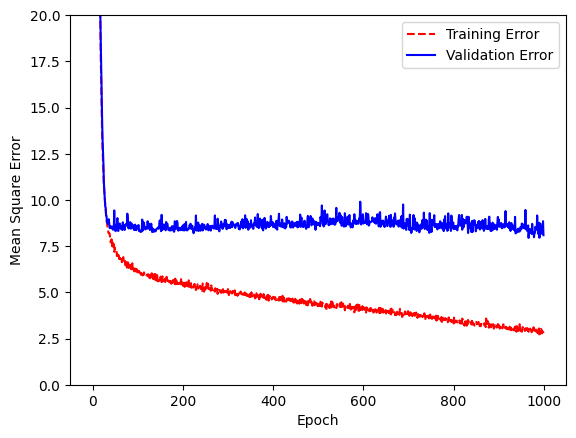

In [23]:
plot_history(history)

En esta gráfica podemos observar perfectamente como se produce overfiting durante el entrenamiento. Podemos ver como a partie de la época 50(aprox) la tasa de errores en los datos de validación augmenta, mientras que en los datos de entrenamiento se va haciendo mas y mas pequeña, esto es poruqe nuestro modelo se esta adaptando a las características de los datos de entrenamiento.
>
Para evitar esta situación podemos hacer uso de un callback que nos ofrece Keras.
>
EarlyStopping evita que nos excedamos de número de epoch parando automáticamente el entreno cuando las métricas de la función de périda para los datos de valifación no mejoran.
>
Con el argumento monutor le indicamos que métrica debe tener en cuenta y con el argumento patience le indicamos cuántas epochs se deben considera para verificar la mejora

In [27]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

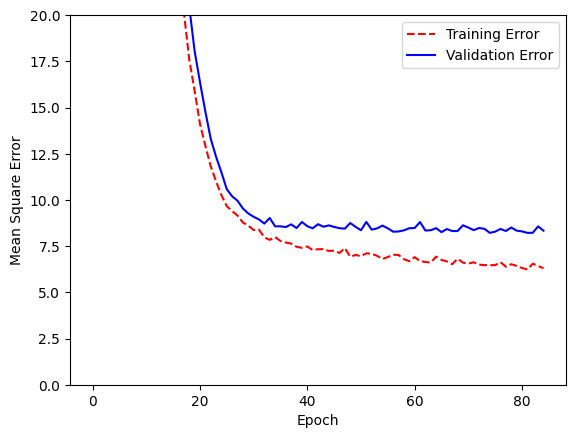

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
model = build_model()
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0,
                    callbacks=[early_stop] )

plot_history(history)




# **Evaluación del modelo con los datos de prueba**


In [29]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Sqr Error: {:5.2f} MPG".format(mse))

3/3 [==============================] - 0s 10ms/step - loss: 5.8261 - mae: 1.8720 - mse: 5.8261
Testing set Mean Abs Error:  5.83 MPG
Testing set Mean Sqr Error:  1.87 MPG


En este caso estamos mas interesados en el error absoluto, porque nos da un error mas comprensible para probar el modelo, es decir, directamente indica la difrerencia de millas por galón.
>
Vemos que el modelo arroja un error de uns 5 millas por galón en caso de MAE, que corresponde a unos 2,26km/litro de erro, es un error pequeño con lo cual podemos concluir que el modelo generaliza bien ,teniendo en cuenta que tenemos un conjunto de datos reducido.

# **Entrenamineto con MAE**
>
Hemos considerado la métrica MAE (mean abs erorr) para evaluar el error, pero habíamos usado la función MSE como función de pérdida, veamos que pasa si usamos la función MAE como función de pérdida.

In [30]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model = build_model()
model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0,
                    callbacks=[early_stop] )


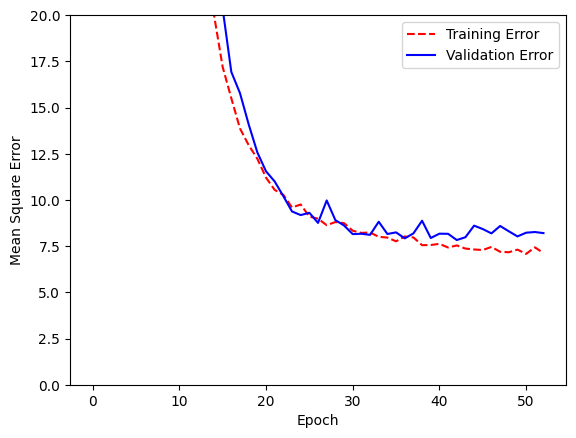

In [31]:
plot_history(history)


In [32]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Sqr Error: {:5.2f} MPG".format(mse))

3/3 [==============================] - 0s 4ms/step - loss: 1.7008 - mae: 1.7008 - mse: 5.2800
Testing set Mean Abs Error:  5.28 MPG
Testing set Mean Sqr Error:  1.70 MPG
